# Rating Prediction Project

## Problem Statement

The project is build for a client who wants to introduce ratings feature in their application. They want a model to predict ratings for their pre-existing reviews.

The project consists of two phase:
       -  Data Collection Phase
       -  Model Building phase

In first phase we have collected reviews from “amazon.in” and “flipkart.com” 

Our goal here is to build a classification model to predict ratings for each review.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import warnings
warnings.filterwarnings('ignore')

In [2]:
## loading training dataset
df=pd.read_csv(r"Ratings_Data.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,Ratings,Reviews
0,0,0,1.0,Laptop getting hang very much and very much sl...
1,1,1,3.0,The package i has received was well protected...
2,2,2,3.0,It looks the screen size is small . Its not lo...
3,3,3,1.0,"HiThis is a true feedback, requesting you to n..."
4,4,4,3.0,How to install a new SSD? The SSD does not sho...


In [3]:
df.drop(columns=["Unnamed: 0","Unnamed: 0.1"],inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52745 entries, 0 to 52744
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ratings  52745 non-null  float64
 1   Reviews  52745 non-null  object 
dtypes: float64(1), object(1)
memory usage: 824.3+ KB


In [5]:
df.isnull().sum()

Ratings    0
Reviews    0
dtype: int64

Our data does not have any null values

In [6]:
df.shape

(52745, 2)

Number of rows = 52745

Number of columns = 2

In [7]:
df["Ratings"].value_counts()

5.0    23857
1.0    14995
4.0     6786
3.0     4551
2.0     2556
Name: Ratings, dtype: int64

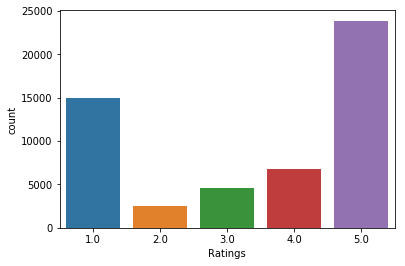

In [8]:
sns.countplot(df["Ratings"]) # Distribution of ratings

In [9]:
df['review_length']=df.Reviews.str.len()
df.head()

,Ratings,Reviews,review_length
0,1.0,Laptop getting hang very much and very much sl...,98
1,3.0,The package i has received was well protected...,415
2,3.0,It looks the screen size is small . Its not lo...,80
3,1.0,"HiThis is a true feedback, requesting you to n...",429
4,3.0,How to install a new SSD? The SSD does not sho...,204


In [10]:
## Removing Stopwords
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=stopwords.words('english')
df['Reviews']=df["Reviews"].apply(lambda x:' '.join([word for word in x.split() if word not in (stop)]))
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rajeev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Ratings,Reviews,review_length
0,1.0,Laptop getting hang much much slow start.This ...,98
1,3.0,The package received well protected damage occ...,415
2,3.0,It looks screen size small . Its look 15.6 inc...,80
3,1.0,"HiThis true feedback, requesting buy laptop he...",429
4,3.0,How install new SSD? The SSD show boot menu. I...,204


In [11]:
# defining function to clean text
def clean_text(df, text):
    
    #Converting all messages to lowercase
    df[text] = df[text].str.lower()

    #Replace email addresses with ' '
    df[text] = df[text].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',' ')

    #Replace URLs with ' '
    df[text] = df[text].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')

    #Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with ' '
    df[text] = df[text].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ')

    #Replace numbers with 'numbr'
    df[text] = df[text].str.replace(r'\d+(\.\d+)?', ' ')

    #Remove punctuation
    df[text] = df[text].str.replace(r'[^\w\d\s]', ' ')

    #Replace whitespace between terms with a single space
    df[text] = df[text].str.replace(r'\s+', ' ')

    #Remove leading and trailing whitespace
    df[text] = df[text].str.replace(r'^\s+|\s+?$', '')

In [12]:
# Cleaning  and storing the comments in a separate feature.
clean_text(df,'Reviews')

In [13]:
df.head()

,Ratings,Reviews,review_length
0,1.0,laptop getting hang much much slow start this ...,98
1,3.0,the package received well protected damage occ...,415
2,3.0,it looks screen size small its look inch can o...,80
3,1.0,hithis true feedback requesting buy laptop her...,429
4,3.0,how install new ssd the ssd show boot menu it ...,204


In [18]:
# Lemmatization
def word_lemmatizer(text):
    result=[]
    text = text.split()
    lem_text=[WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    for token in lem_text:
        if len(token)>=3:
            result.append(token)
    text=' '.join(result)
    return text

df["clean_review"]=df["Reviews"].apply(lambda x: word_lemmatizer(x))
df.head()

,Ratings,Reviews,review_length,clean_review
0,1.0,laptop getting hang much much slow start this ...,98,laptop get hang much much slow start this happ...
1,3.0,the package received well protected damage occ...,415,the package receive well protect damage occur ...
2,3.0,it looks screen size small its look inch can o...,80,look screen size small its look inch can one help
3,1.0,hithis true feedback requesting buy laptop her...,429,hithis true feedback request buy laptop here o...
4,3.0,how install new ssd the ssd show boot menu it ...,204,how install new ssd the ssd show boot menu sho...


We know the list of products of which we have scraped reviews so we will remove those words as they are not much contributing in prediction of rating but there occurrence is too many times.

In [19]:
# Removing Product Name
df['clean_review'] = df['clean_review'].str.replace(r'laptop',' ')
df['clean_review'] = df['clean_review'].str.replace(r'phone',' ')
df['clean_review'] = df['clean_review'].str.replace(r'camera',' ')
df['clean_review'] = df['clean_review'].str.replace(r'headphone',' ')

In [20]:
df['clean_text_length'] = df['clean_review'].apply(lambda x: len(str(x)))
df.head()

,Ratings,Reviews,review_length,clean_review,clean_text_length
0,1.0,laptop getting hang much much slow start this ...,98,get hang much much slow start this happen wi...,64
1,3.0,the package received well protected damage occ...,415,the package receive well protect damage occur ...,230
2,3.0,it looks screen size small its look inch can o...,80,look screen size small its look inch can one help,49
3,1.0,hithis true feedback requesting buy laptop her...,429,hithis true feedback request buy here order ...,255
4,3.0,how install new ssd the ssd show boot menu it ...,204,how install new ssd the ssd show boot menu sho...,143


### Plotting Word Cloud

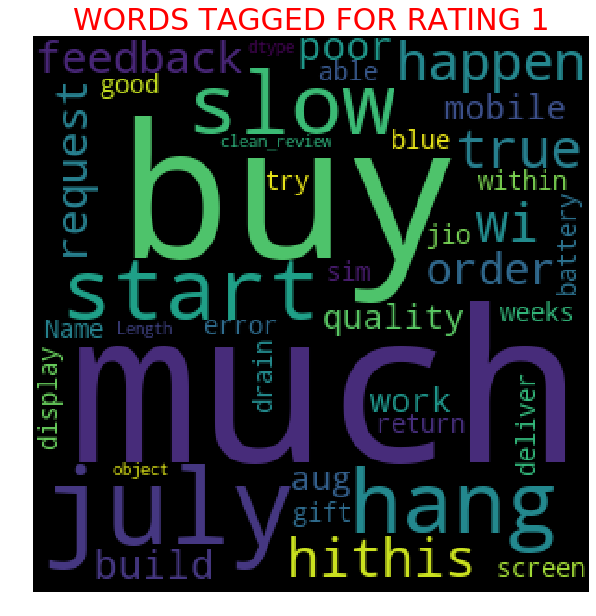

In [21]:
rating1=df[(df['Ratings']==1.0)]

wordcloud=WordCloud(height=300,width=300,max_words=300).generate(str(rating1['clean_review']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED FOR RATING 1',fontdict={'fontsize':30, 'fontweight':30, 'color':'red'})
plt.show()

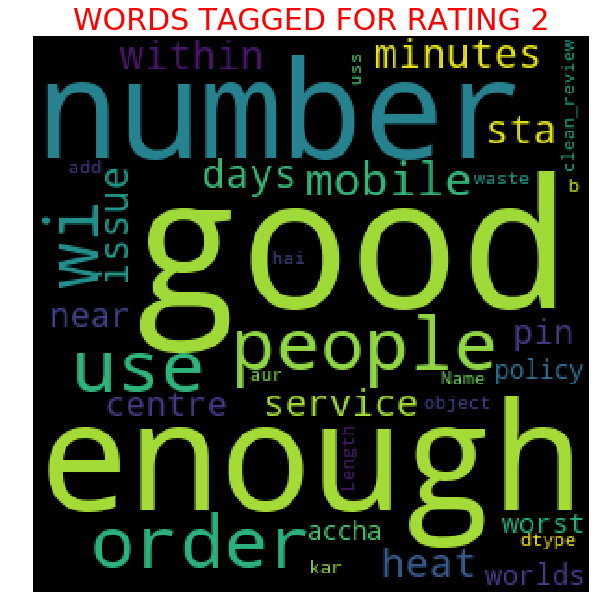

In [22]:
rating2=df[(df['Ratings']==2.0)]

wordcloud=WordCloud(height=300,width=300,max_words=300).generate(str(rating2['clean_review']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED FOR RATING 2',fontdict={'fontsize':30, 'fontweight':30, 'color':'red'})
plt.show()

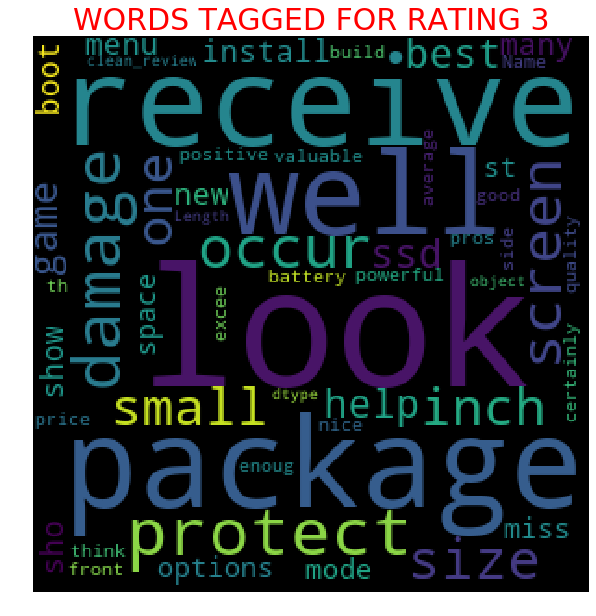

In [23]:
rating3=df[(df['Ratings']==3.0)]

wordcloud=WordCloud(height=300,width=300,max_words=300).generate(str(rating3['clean_review']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED FOR RATING 3',fontdict={'fontsize':30, 'fontweight':30, 'color':'red'})
plt.show()

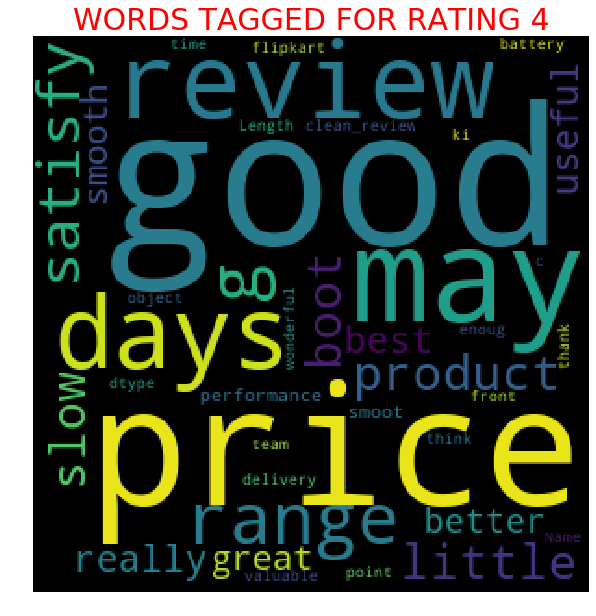

In [24]:
rating4=df[(df['Ratings']==4.0)]

wordcloud=WordCloud(height=300,width=300,max_words=300).generate(str(rating4['clean_review']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED FOR RATING 4',fontdict={'fontsize':30, 'fontweight':30, 'color':'red'})
plt.show()

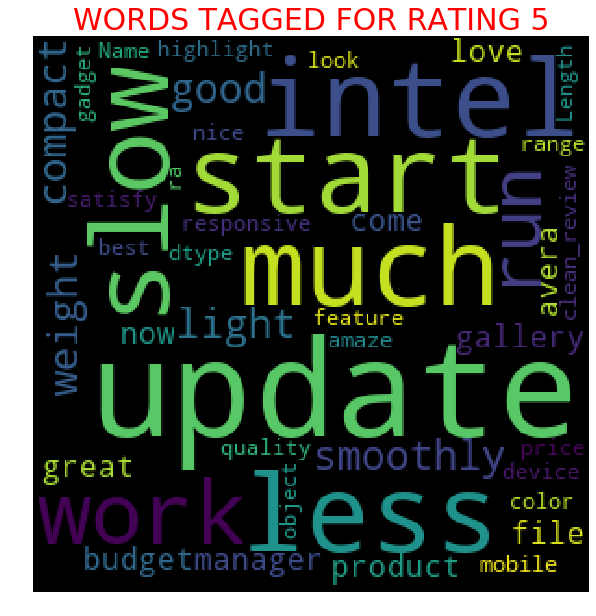

In [25]:
rating5=df[(df['Ratings']==5.0)]

wordcloud=WordCloud(height=300,width=300,max_words=300).generate(str(rating5['clean_review']))
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED FOR RATING 5',fontdict={'fontsize':30, 'fontweight':30, 'color':'red'})
plt.show()

Observations:

- The enlarged texts are the most number of words used there and small texts are the less number of words used.

- It varies according to the ratings.

### Feature Extraction

In [26]:
def Tf_idf_train(text):
    tfid = TfidfVectorizer(min_df=3,smooth_idf=False)
    return tfid.fit_transform(text)
x=Tf_idf_train(df['clean_review'])

print("Shape of x: ",x.shape)

y = df['Ratings'].values
print("Shape of y: ",y.shape)

Shape of x:  (52745, 3809)
Shape of y:  (52745,)


In [27]:
#Importing required libraries
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [28]:
# Determining Best Random State
lr=LogisticRegression()
max_score=0
for r_state in range (42,101):
    x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=r_state,test_size=0.25)
    lr.fit(x_train,y_train)
    pred=lr.predict(x_test)
    acc_score=accuracy_score(y_test,pred)
    if acc_score>max_score:
        max_score=acc_score
        final_r_state=r_state
print("The maximum accuracy score", max_score, "is achieved at", final_r_state)

The maximum accuracy score 0.7775839842268901 is achieved at 80


In [29]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=80,test_size=0.25)

In [30]:
#Initializing the instance of the model
lr=LogisticRegression()
dt=DecisionTreeClassifier()
knn=KNeighborsClassifier()
rf=RandomForestClassifier()
ab=AdaBoostClassifier()
gb=GradientBoostingClassifier()

models= []
models.append(('Logistic Regression',lr))
models.append(('DecisionTreeClassifier',dt))
models.append(('KNeighborsClassifier',knn))
models.append(('RandomForestClassifier',rf))
models.append(('AdaBoostClassifier',ab))
models.append(('GradientBoostingClassifier',gb))

In [31]:
Model=[]
score=[]
cvs=[]
for name,model in models:
    print("***",name,"***")
    Model.append(name)
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    print('\n')
    AS=accuracy_score(y_test,y_pred)
    print('accuracy_score: ',AS)
    score.append(AS*100)
    print('\n')
    sc=cross_val_score(model,x,y,cv=5,scoring='accuracy').mean()
    print('cross_val_score: ',sc)
    cvs.append(sc*100)
    print('\n')
    print('Classification report:\n ')
    print(classification_report(y_test,y_pred))
    print('\n')
    print('Confusion matrix: \n')
    cm=confusion_matrix(y_test,y_pred)
    print(cm)
    print('\n\n')

*** Logistic Regression ***


accuracy_score:  0.7775839842268901


cross_val_score:  0.46123803204095176


Classification report:
 
              precision    recall  f1-score   support

         1.0       0.75      0.81      0.78      3803
         2.0       0.70      0.68      0.69       630
         3.0       0.75      0.65      0.69      1096
         4.0       0.69      0.53      0.60      1682
         5.0       0.82      0.86      0.84      5976

    accuracy                           0.78     13187
   macro avg       0.74      0.71      0.72     13187
weighted avg       0.77      0.78      0.77     13187



Confusion matrix: 

[[3075   56   71  112  489]
 [  58  431   11   68   62]
 [ 161   23  712   54  146]
 [ 275   31   74  892  410]
 [ 507   77   85  163 5144]]



*** DecisionTreeClassifier ***


accuracy_score:  0.7749298551603853


cross_val_score:  0.4116219546876481


Classification report:
 
              precision    recall  f1-score   support

         1.0       0.7

In [32]:
df=pd.DataFrame({'Model':Model, 'Accuracy_score': score,'Cross_val_score':cvs})
df

,Model,Accuracy_score,Cross_val_score
0,Logistic Regression,77.758398,46.123803
1,DecisionTreeClassifier,77.492986,41.162195
2,KNeighborsClassifier,76.272086,42.369893
3,RandomForestClassifier,77.530902,48.243435
4,AdaBoostClassifier,54.159399,50.459759
5,GradientBoostingClassifier,76.014256,53.043890


We observe the gradient boosting and random forest perform better compared to other models. So we will tune theses two models and then finalize the more efficient one.

### Hyper-Parametric Tuning

#### Gradient Boosting Classification

In [18]:
gb= GradientBoostingClassifier()
params={'loss':['deviance'],'n_estimators':[10,15], 'criterion':['mse'],
       'max_depth':[5,7], 'min_samples_split':[4,6],
       'min_samples_leaf':[2,3]}
grd=GridSearchCV(gb,param_grid=params)
grd.fit(x_train,y_train)
print('best params=>',grd.best_params_)

best params=> {'criterion': 'mse', 'loss': 'deviance', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 15}


In [19]:
gb= grd.best_estimator_
gb.fit(x_train,y_train)
y_pred=gb.predict(x_test)
print("Gradient Boosting Classification: Accuracy = ",accuracy_score(y_test,y_pred))
print("\n Confusion Matrix=\n ",confusion_matrix(y_test,y_pred))
print("\n Classification Report=\n ",classification_report(y_test,y_pred))

Gradient Boosting Classification: Accuracy =  0.7219231060893304

 Confusion Matrix=  [[2624    0   24   16 1139]
 [  25  259    1    6  339]
 [ 149    0  516   11  420]
 [ 247   21   32  613  769]
 [ 378   32   17   41 5508]]

 Classification Report=                precision    recall  f1-score   support

         1.0       0.77      0.69      0.73      3803
         2.0       0.83      0.41      0.55       630
         3.0       0.87      0.47      0.61      1096
         4.0       0.89      0.36      0.52      1682
         5.0       0.67      0.92      0.78      5976

    accuracy                           0.72     13187
   macro avg       0.81      0.57      0.64     13187
weighted avg       0.75      0.72      0.71     13187



#### Random Forest Classification

In [20]:
rmf= RandomForestClassifier()
params={'n_estimators':[13,15], 'criterion':['entropy'],
       'max_depth':[10], 'min_samples_split':[10,11],
       'min_samples_leaf':[5,6]}
grd_r=GridSearchCV(rmf,param_grid=params)
grd_r.fit(x_train,y_train)
print('best params=>',grd_r.best_params_)

best params=> {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 15}


In [21]:
rmf= grd_r.best_estimator_
rmf.fit(x_train,y_train)
y_pred=rmf.predict(x_test)
print("Random Forest Classification: Accuracy = ",accuracy_score(y_test,y_pred))
print("\n Confusion Matrix= ",confusion_matrix(y_test,y_pred))
print("\n Classification Report= ",classification_report(y_test,y_pred))

Random Forest Classification: Accuracy =  0.5877000075832259

 Confusion Matrix=  [[1395    0    4    0 2404]
 [  67   59    1    9  494]
 [  91    0  299    0  706]
 [  79    0   32  163 1408]
 [ 134    0    6    2 5834]]

 Classification Report=                precision    recall  f1-score   support

         1.0       0.79      0.37      0.50      3803
         2.0       1.00      0.09      0.17       630
         3.0       0.87      0.27      0.42      1096
         4.0       0.94      0.10      0.18      1682
         5.0       0.54      0.98      0.69      5976

    accuracy                           0.59     13187
   macro avg       0.83      0.36      0.39     13187
weighted avg       0.71      0.59      0.52     13187



#### Finalizing and saving our model

We observe Gradient Boosting Classifier performs better than random forest and hence we will finalize it as our model.

In [23]:
## savig model
import pickle
filename= "RatingPrediction.pickle"
pickle.dump(gb, open(filename, 'wb'))